In [197]:
import pandas as pd
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = '{:,.2f}'.format

from sklearn.model_selection import train_test_split

seed=42
np.random.seed = 42

In [198]:
def calculate_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with features removed
    '''
    const=add_constant(df)
    cols=const.columns
    variables=np.arange(const.shape[1])
    vif_df=pd.Series([variance_inflation_factor(const.values, i) 
               for i in range(const.shape[1])], 
              index=const.columns).to_frame()

    vif_df=vif_df.sort_values(by=0, ascending=False).rename(columns={0: 'VIF'})
    vif_df=vif_df.drop('const')
    vif_df=vif_df[vif_df['VIF'] > thresh]

    print('Features above VIF threshold:\n')
    print(vif_df[vif_df['VIF'] > thresh])

    col_to_drop = list(vif_df.index)

    for i in col_to_drop:
        print('Dropping: {}'.format(i))
        df = df.drop(columns=i)

    return 'done'

In [199]:
#columns
dtype_list = ['usableAreas','totalAreas','parkingSpaces','suites','bedrooms'
,'pricingInfos_price','pricingInfos_yearlyIptu','pricingInfos_monthlyCondoFee']

dataset['interestingFlag'] = dataset['interestingFlag'].map({True:1, False:0}).astype('float')

In [200]:
#reading
dataset = pd.read_csv('data/processed/train_cleaned.csv.gzip',compression='gzip', sep =';')
dataset[[x for x in dtype_list]] = dataset[[x for x in dtype_list]].astype('float')

/home/villy/Desktop/git/imoveis/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [201]:
#olhando as features 
_=dataset.address_neighborhood.nunique()/dataset[dataset.usableAreas!=0].shape[0]
print(f'razão: # de bairros/# de linhas = {_:.2f}')

razão: # de bairros/# de linhas = 0.03


In [202]:
_=dataset[dataset.usableAreas==0]['id'].count()/dataset.shape[0]
print(f'razão: # de área igual à 0/# de linhas = {_:.2f}')

razão: # de área igual à 0/# de linhas = 0.37


In [203]:
teste = dataset[(dataset['usableAreas']>30)&(dataset['usableAreas']<150000)]

### olhando a colireariedade, nos dados contínuos
e torcendo

In [204]:
aux_list = ['usableAreas','parkingSpaces','suites','bedrooms'
,'pricingInfos_yearlyIptu','pricingInfos_monthlyCondoFee']
aux_df=dataset[(dataset['usableAreas']>0)&(dataset['pricingInfos_yearlyIptu']>0)
               &(dataset['pricingInfos_monthlyCondoFee']>0)]

calculate_vif_(aux_df[aux_list],5)

Features above VIF threshold:

Empty DataFrame
Columns: [VIF]
Index: []


'done'

Perceba que não há nada colinear, uhul

In [ ]:
dataset['usableAreas_flg']=dataset['usableAreas'].apply(lambda x: 1 if x>0 else 0)
dataset['interestingFlag']=dataset['interestingFlag'].apply(lambda x: 1 if x else 0)

dataset.interestingFlag.fillna(0, inplace=True)

#### Train/test

In [206]:
from sklearn import preprocessing

dataset=dataset[(dataset['usableAreas']>10)&(dataset['pricingInfos_price']<1000000)]
dataset=pd.get_dummies(dataset, columns=["address_zone"])

x_col=['usableAreas', 'parkingSpaces', 'suites', 'bedrooms'
,'bathrooms', 'pricingInfos_yearlyIptu', 'pricingInfos_monthlyCondoFee','interestingFlag'
, 'address_zone_Centro','address_zone_Zona Leste','address_zone_Zona Oeste', 'address_zone_Zona Sul']

x=dataset[x_col]
y=dataset['pricingInfos_price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

x_train_sc = preprocessing.scale(x_train)
x_test_sc = preprocessing.scale(x_test)

#### Regression

In [207]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,mean_absolute_error

_x = sm.add_constant(pd.DataFrame(x_train_sc, columns=x_col))
est = sm.OLS(pd.DataFrame(y_train.values, columns=['price']), _x)
est = est.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     4017.
Date:                Tue, 13 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:40:52   Log-Likelihood:            -3.3608e+05
No. Observations:               25440   AIC:                         6.722e+05
Df Residuals:                   25427   BIC:                         6.723e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         4.326e+05    828.938    521.891      0.000    4.31e+05    4.34e+05
usableAreas                   8.085e+04   1373.639     58.860      0.000    7.82e+04    8.35e+04
parkingSpaces                 2.007e+04   1143.658     17.550      0.000    1.78e+04    2.23e+04
suites                        2.782e+04   1194.135     23.295      0.000    2.55e+04    3.02e+04
bedrooms                     -6906.3900   1136.300     -6.078      0.000   -9133.603   -4679.177
bathrooms                     2.998e+04   1215.069     24.675      0.000    2.76e+04    3.24e+04
pricingInfos_yearlyIptu       3.448e+04    873.426     39.478      0.000    3.28e+04    3.62e+04
pricingInfos_monthlyCondoFee  5.372e+04   1011.378     53.119      0.000    5.17e+04    5.57e+04
interestingFlag               8276.3673    831.953      9.948      0.000    6645.692    9907.043
address_zone_Centro           3.381e+04   1016.536     33.257      0.000    3.18e+04    3.58e+04
address_zone_Zona Leste       6210.5622   1088.603      5.705      0.000    4076.837    8344.287
address_zone_Zona Oeste       3.736e+04   1054.623     35.428      0.000    3.53e+04    3.94e+04
address_zone_Zona Sul         4.287e+04   1181.406     36.291      0.000    4.06e+04    4.52e+04
==============================================================================
Omnibus:                     2532.178   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19420.911
Skew:                           0.130   Prob(JB):                         0.00
Kurtosis:                       7.273   Cond. No.                         4.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [208]:
_ = sm.add_constant(pd.DataFrame(x_test_sc, columns=x_col))
y_pred = est.predict(exog=_)

mse =mean_squared_error(y_test, y_pred,squared=False)
mae=mean_absolute_error(y_test, y_pred)
print(f'mse:{mse}\nmae:{mae}')

mse:128184.17508143345
mae:94735.68247754152


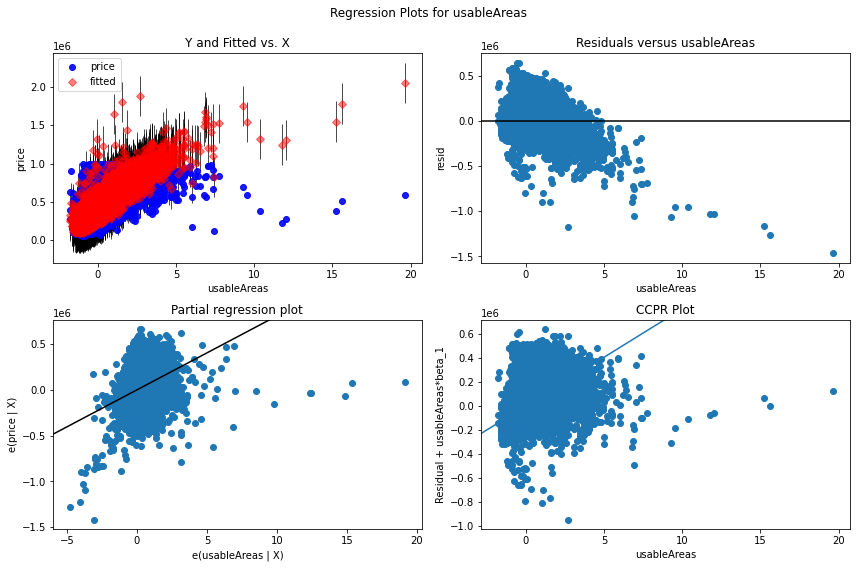

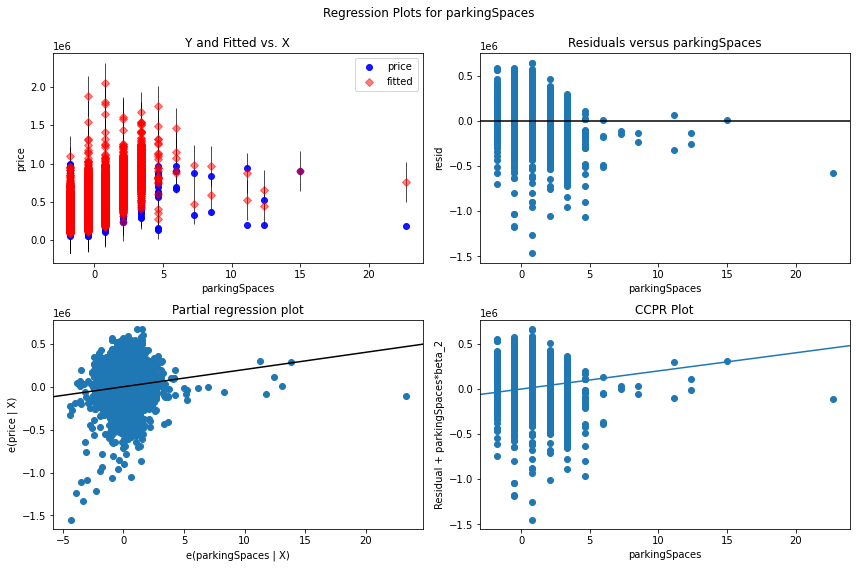

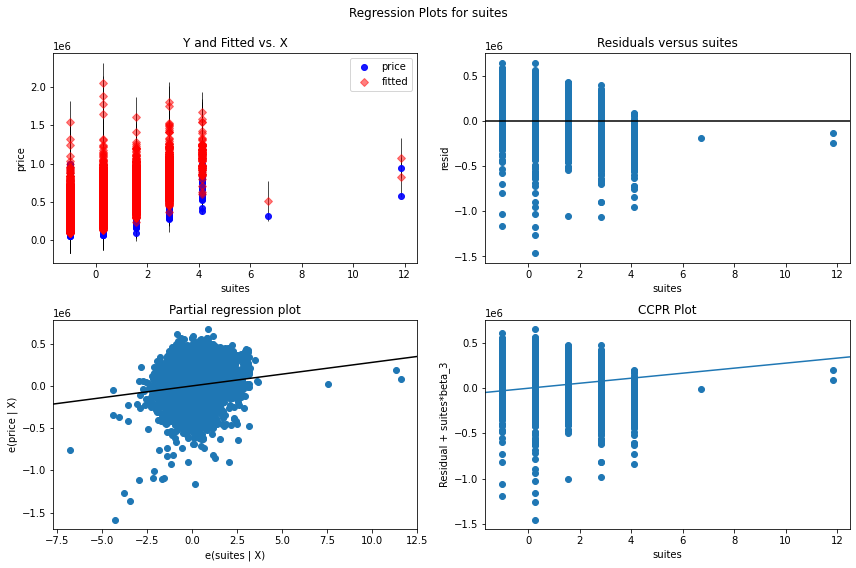

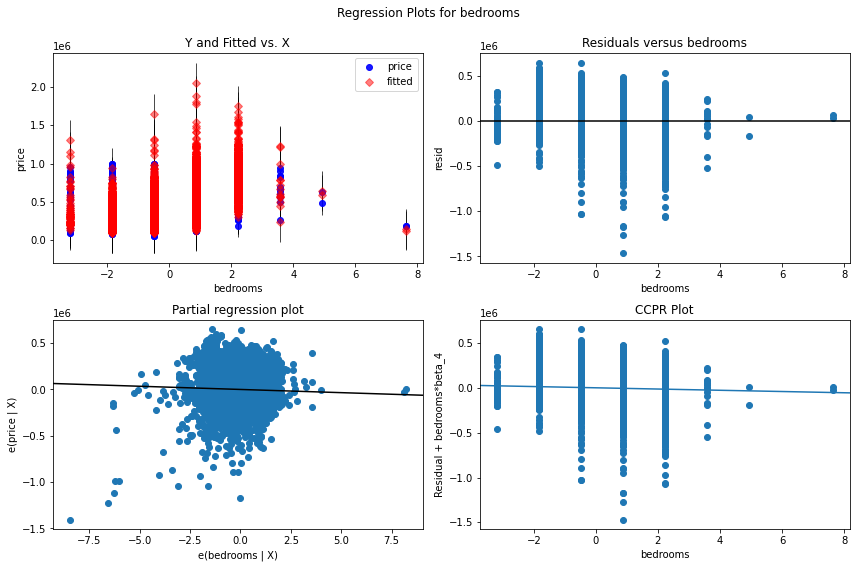

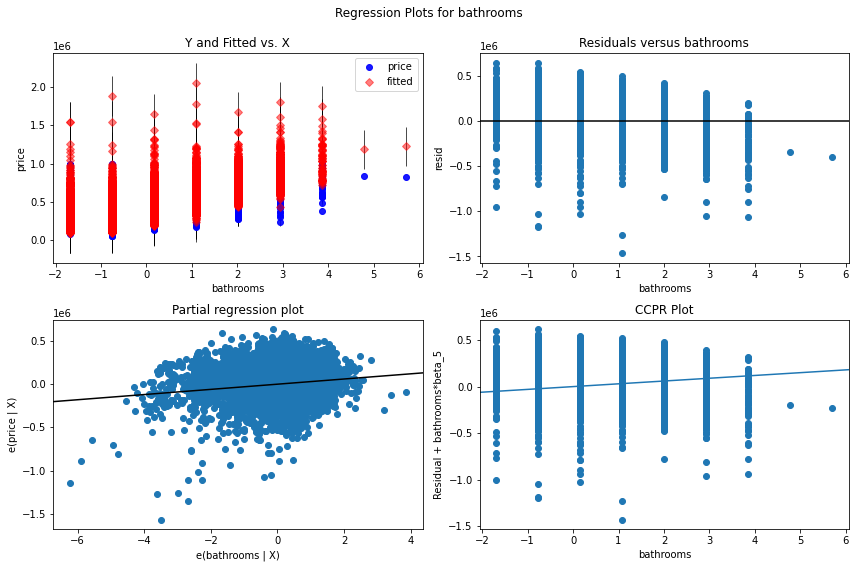

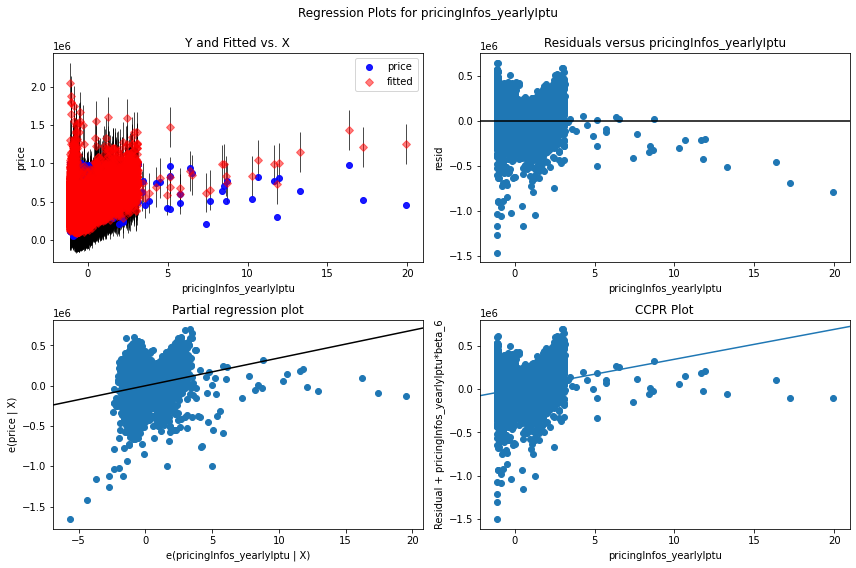

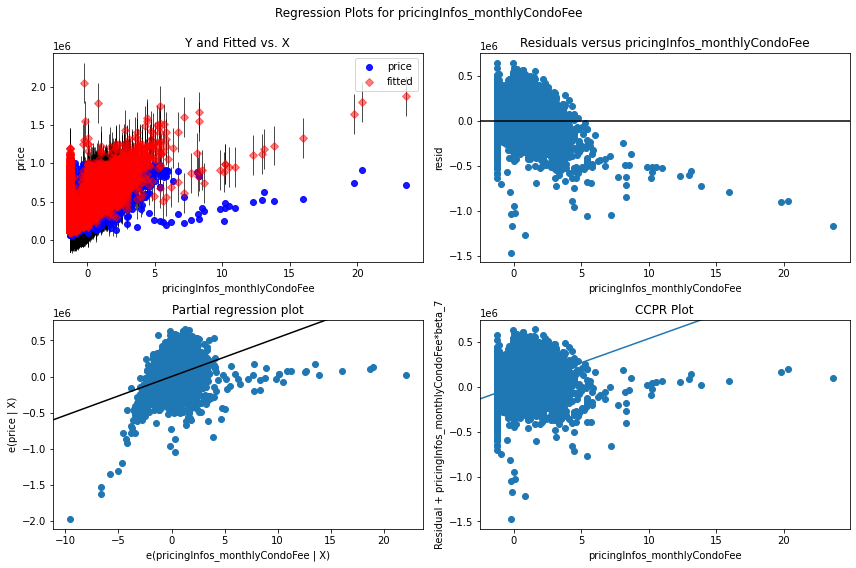

In [209]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

res_list=['usableAreas', 'parkingSpaces', 'suites', 'bedrooms'
,'bathrooms', 'pricingInfos_yearlyIptu', 'pricingInfos_monthlyCondoFee']

for i in res_list:
    fig = plt.figure(figsize=(12,8))
    fig = sm.graphics.plot_regress_exog(est, i, fig=fig)

#### conclusão

Percebemos que o MAE e MSE ficaram um pouco grande
Os resíduos deram uma estourada quanto maior o valor da var. explicativa.
Assim, acredito que um pouco mais de pré-processing seria um bom caminho assim como dividir o modelo em mais faixas de menor de preço. 

Regression - RF

In [210]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

n_estimators=[20,50,60,100]
max_features=['auto','sqrt','log2']
max_depth=[2,5,9,13,18,24,26]
min_samples_split=[2,5,7,10]
min_samples_leaf=[6,8,12,18]

paramns={'n_estimators':n_estimators,
'max_features':max_features,
'max_depth':max_depth,
'min_samples_split':min_samples_split,
'min_samples_leaf':min_samples_leaf
}
rfg = RandomForestRegressor(random_state=seed)
rfg_cv=RandomizedSearchCV(estimator=rfg
                         ,param_distributions=paramns
                         ,cv=10
                         ,n_jobs=-1
                         ,random_state=seed)

rfg_cv = rfg_cv.fit(x,y)

In [211]:
mse=mean_squared_error(y_test, rfg_cv.predict(x_test),squared=False)
mae=mean_absolute_error(y_test, rfg_cv.predict(x_test))
print(f'mse:{mse}\nmae:{mae}')

mse:61812.25087812361
mae:35104.23943685233


In [212]:
"""
rfg_cv.best_params_ ={'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 6,
 'max_features': 'log2',
 'max_depth': 24}
"""
rfg_2=RandomForestRegressor(n_estimators=100
,min_samples_split=5,min_samples_leaf=6
,max_features='log2' ,max_depth=24 ,random_state=seed).fit(x,y)

In [213]:
pd.DataFrame(data={'importance':rfg_2.feature_importances_
             ,'name':x.columns.values})

,importance,name
0,0.29,usableAreas
1,0.08,parkingSpaces
2,0.05,suites
3,0.03,bedrooms
4,0.10,bathrooms
5,0.23,pricingInfos_yearlyIptu
6,0.19,pricingInfos_monthlyCondoFee
7,0.00,interestingFlag
8,0.00,address_zone_Centro
9,0.01,address_zone_Zona Leste


#### conclusão
esse modelo apresenta performance bem mais interessante e é muito mais fácil de explicar para o usuário final, na medida que o feat importance é muito intuitivo.

In [216]:
import pickle
pickle.dump(rfg_2, open('model/RandomForestRegressor.sav', 'wb'))